In [1]:
import pandas as pd
import os 
import glob
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from imblearn.ensemble import BalancedRandomForestClassifier


print("done")


done


In [2]:
def create_windows(data, sample_rate):
    start_time = data['timestamp'].iloc[0]
    end_time = data['timestamp'].iloc[-1]
    
    intervals = pd.date_range(start=start_time, end=end_time, freq = '1s')
    
    windows = []
    labels = []
    
    for i in range(len(intervals) - 1):
        start = intervals[i]
        end = intervals[i+1]
        
        window_data = data[(data['timestamp'] >= start) & (data['timestamp'] < end)]
        
        if len(window_data) >= sample_rate:
            windows.append(window_data[['thigh_x', 'thigh_y', 'thigh_z']].values)
            
            labels.append(window_data['label'].mode()[0])
            
    return windows, labels
print("Done") 

Done


In [3]:
def extract_features(windows):
    features = []

    for i, window in enumerate(windows):

        feature_dict = {}
        x, y, z = window[:, 0], window[:, 1], window[:, 2]

        # Basic Features
        feature_dict['X_mean'] = np.mean(x)
        feature_dict['Y_mean'] = np.mean(y)
        feature_dict['Z_mean'] = np.mean(z)

        feature_dict['X_stdev'] = np.std(x)
        feature_dict['Y_stdev'] = np.std(y)
        feature_dict['Z_stdev'] = np.std(z)

        feature_dict['X_range'] = np.max(x) - np.min(x)
        feature_dict['Y_range'] = np.max(y) - np.min(y)
        feature_dict['Z_range'] = np.max(z) - np.min(z)

        # Correlation Features (with safety checks)
        feature_dict['Corr_xy'] = safe_corrcoef(x, y)
        feature_dict['Corr_yz'] = safe_corrcoef(y, z)
        feature_dict['Corr_xz'] = safe_corrcoef(x, z)

        # Vector Magnitude
        vector_magnitude = np.sqrt(x**2 + y**2 + z**2)
        feature_dict['||e||2_mean'] = np.mean(vector_magnitude)
        feature_dict['||e||2_range'] = np.max(vector_magnitude) - np.min(vector_magnitude)
        feature_dict['||e||2_median'] = np.median(vector_magnitude)
        feature_dict['||e||2_skew'] = skew(vector_magnitude)
        feature_dict['||e||2_stdev'] = np.std(vector_magnitude)
        feature_dict['||e||2_absdev'] = np.mean(np.abs(vector_magnitude - np.mean(vector_magnitude)))

        # Kurtosis
        feature_dict['kurtosis'] = kurtosis(vector_magnitude)

        # Power Spectral Features
        fft_vals = np.abs(fft(vector_magnitude))
        feature_dict['Pow1'] = np.sum(fft_vals[:len(fft_vals)//4])
        feature_dict['Pow2'] = np.sum(fft_vals[len(fft_vals)//4:len(fft_vals)//2])

        features.append(feature_dict)

    features_df = pd.DataFrame(features)

    features_df.fillna(0, inplace=True)
    features_df.replace([np.inf, -np.inf], 0, inplace=True)

    return features_df


# Safe correlation calculation
def safe_corrcoef(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return np.nan  # or 0
    return np.corrcoef(a, b)[0, 1]
print("Complete")

Complete


In [4]:
folder_path = 'thigh_dataset/harth/training_data'

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

sample_rate = 50
all_features = []
all_labels = []

for file in csv_files:
    df = pd.read_csv(file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    data = df.sort_values(by='timestamp')

    thigh_data = data[['timestamp', 'thigh_x', 'thigh_y', 'thigh_z', 'label']]
    windows, labels = create_windows(thigh_data, sample_rate)

    print(f"No. of 1-s windows created: {len(windows)}")
    if len(windows) > 0:
        features_df = extract_features(windows)
        all_features.append(features_df)
        all_labels.extend(labels)

print("Feature extraction complete.")


No. of 1-s windows created: 7394
No. of 1-s windows created: 6686
No. of 1-s windows created: 5932
No. of 1-s windows created: 7329
No. of 1-s windows created: 3568
No. of 1-s windows created: 6006
No. of 1-s windows created: 2747
No. of 1-s windows created: 7265
No. of 1-s windows created: 8334
No. of 1-s windows created: 4086
No. of 1-s windows created: 7075
No. of 1-s windows created: 8345
No. of 1-s windows created: 3397
No. of 1-s windows created: 7615
No. of 1-s windows created: 3156
No. of 1-s windows created: 6405
No. of 1-s windows created: 7022
Feature extraction complete.


In [5]:

X = pd.concat(all_features, ignore_index=True)
y = all_labels


brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X, y)

print("Training Complete")

Training Complete


In [6]:
joblib.dump(brf, 'activity_brf.pkl')
print("Model saving complete")

Model saving complete


In [7]:

activity_mapping = {
    1: "Walking",
    2: "Running",
    3: "Shuffling",
    4: "Stairs (Ascending)",
    5: "Stairs (Descending)",
    6: "Standing",
    7: "Sitting",
    8: "Lying",
    13: "Cycling (Sit)",
    14: "Cycling (Stand)",
    130: "Cycling (Sit, Inactive)",
    140: "Cycling (Stand, Inactive)"
}

loaded_model = joblib.load('activity_brf.pkl')

test_data_folder = 'thigh_dataset/harth/test_data'

all_true_labels = []
all_predicted_labels = []

for file_name in os.listdir(test_data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(test_data_folder, file_name)
        
        new_data = pd.read_csv(file_path)
        
        new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])
        
        new_data = new_data.sort_values(by='timestamp')
        
        new_windows, new_labels = create_windows(new_data, sample_rate)
        if len(new_windows) == 0:
            print(f"No valid windows found in {file_name}. Skipping...")
            continue
        
        new_features = extract_features(new_windows)
        new_features.fillna(0, inplace=True)  
        
        predictions = loaded_model.predict(new_features)
        
        predicted_activities = [activity_mapping.get(pred, "Unknown") for pred in predictions]
        
        all_true_labels.extend(new_labels)  
        all_predicted_labels.extend(predictions)  
        print(f"Processed file: {file_name}")

        

print("Complete")

Processed file: S025.csv
Processed file: S026.csv
Processed file: S028.csv
Processed file: S009.csv
Processed file: S017.csv
Complete


In [8]:
print("Model Evaluation:")
print("Accuracy:", accuracy_score(all_true_labels, all_predicted_labels))
print("Classification Report:\n", classification_report(all_true_labels, all_predicted_labels, zero_division = 0, target_names=list(activity_mapping.values())))


Model Evaluation:
Accuracy: 0.6785054311083066
Classification Report:
                            precision    recall  f1-score   support

                  Walking       0.93      0.74      0.83      5618
                  Running       0.93      0.72      0.81      1015
                Shuffling       0.22      0.47      0.30       415
       Stairs (Ascending)       0.12      0.65      0.20       412
      Stairs (Descending)       0.14      0.35      0.20       403
                 Standing       0.90      0.74      0.81      1265
                  Sitting       0.93      0.91      0.92      4665
                    Lying       0.74      0.72      0.73      1307
            Cycling (Sit)       0.94      0.47      0.63      5501
          Cycling (Stand)       0.21      0.48      0.29       943
  Cycling (Sit, Inactive)       0.47      0.72      0.57       510
Cycling (Stand, Inactive)       0.06      0.08      0.07       133

                 accuracy                           0.68

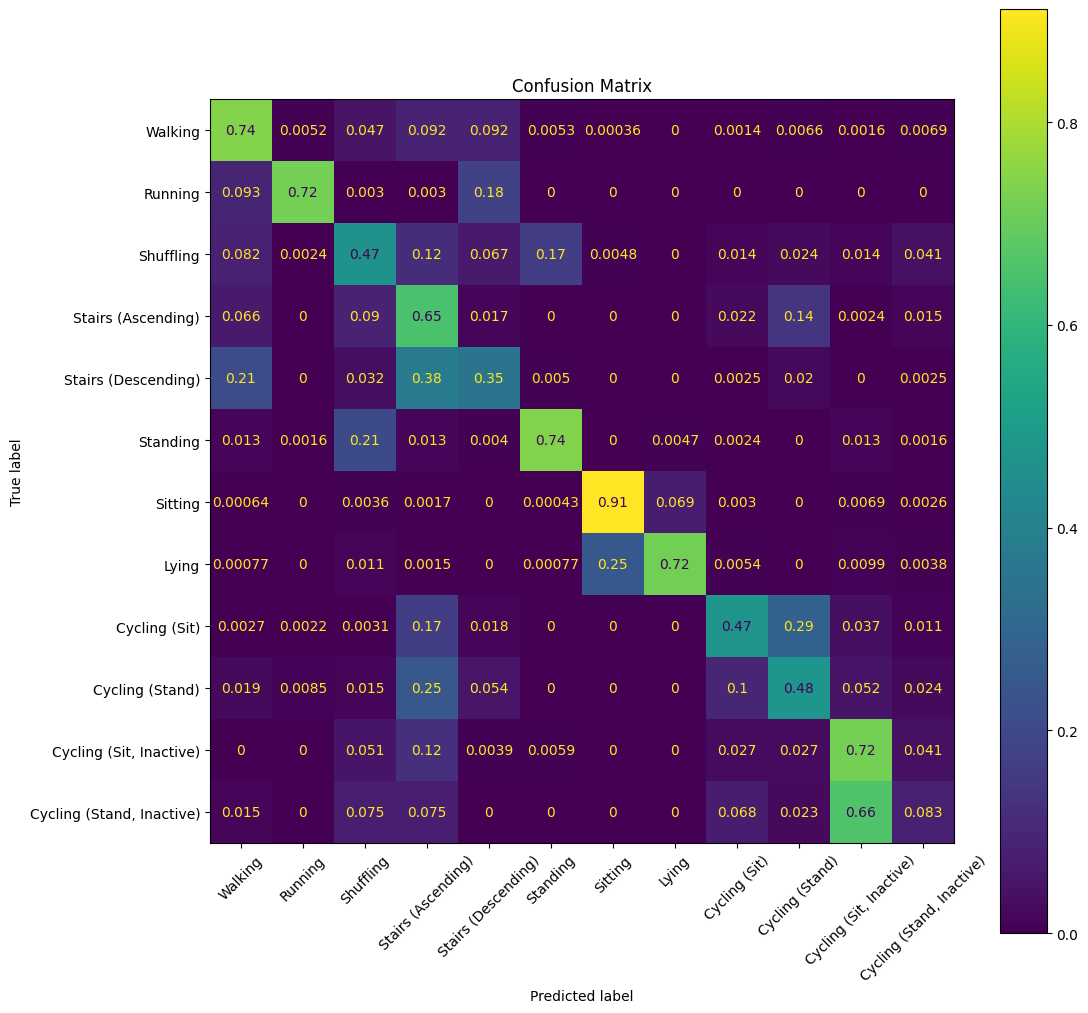

In [9]:
# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels, normalize='true')
classes = list(activity_mapping.values()) 

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.viridis, xticks_rotation=45, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()